## Joanna Piega 
# Praca domowa 3


# Budowa modelu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
matplotlib.style.use('ggplot')
data = pd.read_stata("data.dta")

Zmienne, na podstawie których zostanie zbudowany model to:
    * q26 - odpowiada za informację czy partnerzy byli studentami jednej uczelni
    * ppeducat - odpowiada za poziom wykształcenia
    * q24_met_online - czy partnerzy poznali się online
    * how_long_relationship - jak długo trwa związek
    * age_difference - jaka jest różnica wieku między partnerami

## Przekształcenie danych na dane numeryczne

In [2]:
data = data[["s1","age_difference","q26","ppeducat","q24_met_online","how_long_relationship","q16"]]
data = data[data.isnull().sum(axis = 1) == 0]
data.q24_met_online = pd.Categorical(data.q24_met_online).codes
data.ppeducat = pd.Categorical(data.ppeducat).codes
data.q26 = pd.Categorical(data.q26).codes
data.s1 = pd.Categorical(data.s1).codes

## Podział danych na zbiór treningowy i testowy

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,1:6],data.s1, test_size = 0.10, random_state = 0)

## Stworzenie modelu predykcyjnego - XGBoost

In [4]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10)
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)

## Ocena jakości zbudowanego modelu

Accuracy

In [5]:
from sklearn.metrics import accuracy_score
round(accuracy_score(Y_test, [round(i) for i in y_pred]),2)*100

75.0

## Break down

Implementacja metody:

In [319]:
def break_down(model, order, x2, set):
    x=x2.copy()
    y=set.copy()
    prediction=[pd.DataFrame(model.predict_proba(y)).iloc[:,0].mean()]
    for i in order:
        y.iloc[:,order[i]]=[x[order[i]]]*set.shape[0]
        prediction.append(pd.DataFrame(model.predict_proba(y)).iloc[:,0].mean())
    prediction.append(prediction[5])
    
    name = ["Intercept"]+[i + str("=")+str(x[i])for i in (x.index)[order]]+["Total"]
    x=[round(i,2) for i in prediction][::-1]
    
    name=name[::-1]
    k = [x[6]]+[x[::-1][i]-x[::-1][i-1] for i in range(1,6)]
    k=k+[prediction[5]]
    top = [0]+x[::-1][0:6]
    bottom = [min(x[::-1][i],top[i]) for i in range(7)]
    top = [max(x[::-1][i],top[i]) for i in range(7)]
    
    k=[str("+")+str(round(v*100,2))+str("%")  if v>0 else str(round(v*100,2))+str("%") for v in k ][::-1]

    colours = ["lightcoral" if v[0]=="-" else "lightgreen" for v in k]


    fig, ax = plt.subplots()    
    width = 0.75 
    ind = np.arange(len(x)) 
    ax.barh(ind, top[::-1], width, color=colours)
    ax.barh(ind,bottom[::-1], width, color=["lightgreen"]+["w"]*5+["green"]*2)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(name, minor=False)
    plt.title('Break down')
    plt.xlabel('probability')
    plt.ylabel('variable')   
    plt.xlim([0, max(x)+0.1])

    
    for i in range(len(k)):
        ax.text(0.05, i - .1, k[i], color='darkblue', fontweight='bold')
        
    plt.show()

## Wyjaśnienie modelu

Będziemy wykonywać analizy dla następującej obserwacji:

In [320]:
X_test.loc[1262]

age_difference           0.0
q26                      1.0
ppeducat                 3.0
q24_met_online           0.0
how_long_relationship    4.0
Name: 1262, dtype: float64

Tzn. mamy do czynienia z parą w tym samym wieku, która kończyła tan sam uniwersytet i jest w związku od 4 lat.

In [321]:
x=X_test.loc[1262]
order1=[0 ,2, 4, 3, 1]
order2=[3 ,2 ,0 ,4 ,1]

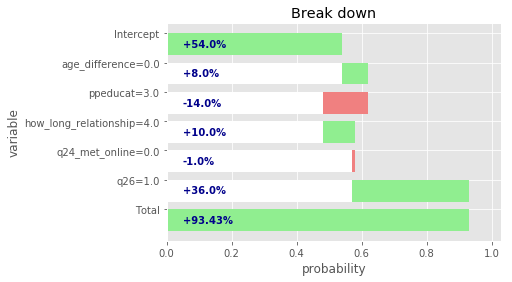

In [322]:
break_down(model, order1, x, X_test )

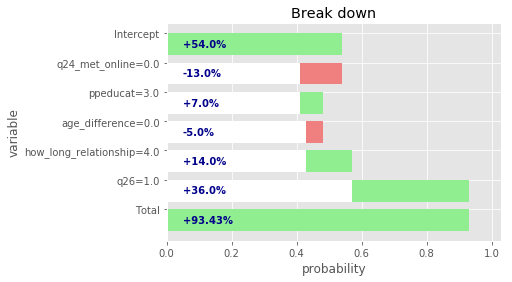

In [323]:
break_down(model, order2, x, X_test )

## Wnioski

Rozważane przypadki kolejności warunkowania różnią się kolejnością trzech zmiennych: q24, age_difference i how_long_relationship. Ciekawym zjawiskiem jest fakt, że szansa małżeństwa dla partnerów z wyższym wyształceniem maleje o 14 punktów procentowych, gdy będziemy rozważać tylko pary w tym samym wieku, zaś rośnie o 7 pktów procentowych w przypadku, gdy pod uwagę bierzemy pary, które poznały się przez interenet. W rezultacje jednak po warunkowaniu na te dwie zmienne osobno - pstwo małżeństwa dla pary z wyższym wyształceniem jest takie samo - 0.48. Może to świadczyć o braku korelacji zmiennych ppeducat z age_difference oraz ppeduc z q24. Podobna sytuacja zachodzi dla zmiennej odpowiedzialnej za różnicę wieku. W ogólności równy wiek partnerów zwiększa szansę małżeństwa, lecz po zwarunkowaniu na wyższe wykształcenie i nie poznaniu się przez internet - owa szansa maleje. Ciekawym wnioskiem na przyszłość jest fakt, że ukończenie tej samej uczelni znacząco (o 36pkt.%) zwiększa szansę małżeństwa.